In [1]:
import pyodbc
import pandas as pd
import seaborn as sns

server = "localhost,5432"
db_name = "ModMon"
driver = "/usr/local/lib/psqlodbcw.so"

cnxn = pyodbc.connect("DRIVER={" + driver + "};SERVER=" + server + ";DATABASE=" + db_name + ";Trusted_Connection=yes;")
cursor = cnxn.cursor()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
models = pd.read_sql('SELECT models.modelID, models.name, models.teamName, models.description, researchQuestions.description AS question FROM models, researchQuestions WHERE models.questionID=researchQuestions.questionID;', cnxn)
models

,modelid,name,teamname,description,question
0,1,WineQuality1,REG,Model to assess wine quality,Investigate wine quality dataset
1,2,wine-lightgbm,REG2,Model to assess wine quality,Investigate WHITE wine quality dataset


Visualisation ideas
==

In [3]:
results = pd.read_sql('SELECT * FROM results;', cnxn)
results.head()

,modelid,modelversion,testdatasetid,isreferenceresult,runtime,runid,metric,value,valueerror,resultmessage
0,1,1.0.0,2,1,2020-07-11,1,training_time,0.190425,None,None
1,1,1.0.0,2,1,2020-07-11,1,r2,-0.026282,None,None
2,1,1.0.0,2,1,2020-07-11,1,mse,0.803185,None,None
3,1,1.0.0,2,1,2020-07-11,1,mar,0.625153,None,None
4,2,0.0.1,4,1,2020-07-11,2,correct_class,0.742258,None,None


## View a particular model version - all metrics across time

- Use runID as a proxy for time

In [8]:
plot1_results = pd.read_sql("SELECT * FROM results WHERE modelID=1 AND modelVersion='1.0.0';", cnxn)

In [14]:
plot1_results['metric']

0              mar
1              mse
2               r2
3    training_time
4              mar
5              mse
6               r2
Name: metric, dtype: object

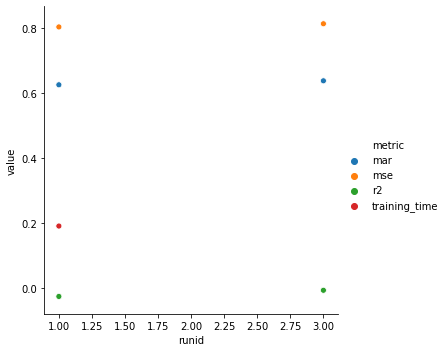

In [9]:
sns.relplot(x='runid', y='value', hue='metric', data=plot1_results)

## View a particular model - all metrics across versions

In [10]:
plot2_results = pd.read_sql("SELECT * FROM results WHERE modelID=1;", cnxn)

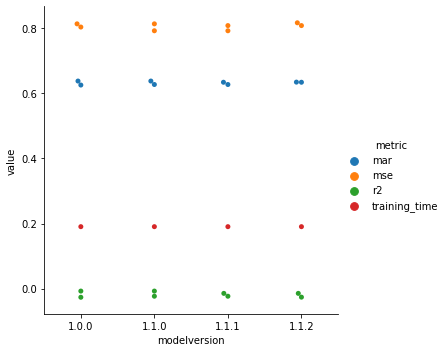

In [11]:
sns.catplot(x='modelversion', y='value', hue='metric', kind='swarm', data=plot2_results)

## View a particular research question - all models for a metric common to all across time

- Also inlcude model versions?

In [ ]:
###

## View a particular metric for a model across time and for different versions

In [12]:
plot3_results = pd.read_sql("SELECT * FROM results WHERE modelID=1 AND metric='r2';", cnxn)
plot3_results

,modelid,modelversion,testdatasetid,isreferenceresult,runtime,runid,metric,value,valueerror,resultmessage
0,1,1.0.0,2,1,2020-07-11 00:00:00,1,r2,-0.026282,None,None
1,1,1.0.0,5,0,2020-07-02 14:13:14,3,r2,-0.007283,None,None
2,1,1.1.0,5,0,2020-07-02 14:14:47,7,r2,-0.023084,None,None
3,1,1.1.0,7,1,2020-07-11 00:00:00,5,r2,-0.007283,None,None
4,1,1.1.1,5,0,2020-07-02 14:22:05,12,r2,-0.014353,None,None
5,1,1.1.1,13,1,2020-07-11 00:00:00,10,r2,-0.023084,None,None
6,1,1.1.2,5,0,2020-07-02 14:41:42,16,r2,-0.025926,None,None
7,1,1.1.2,17,1,2020-07-11 00:00:00,14,r2,-0.014353,None,None


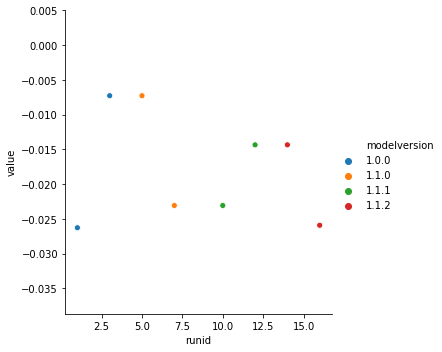

In [13]:
sns.relplot(x='runid', y='value', hue='modelversion', data=plot3_results)